In [10]:
import networkx as nx
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.1'

In [63]:
# 获取Piedmont的网络，计算其基本统计数据，然后显示平均弯曲度
G = ox.graph.graph_from_place("Baltimore, Maryland, USA", network_type="drive", simplify=True)

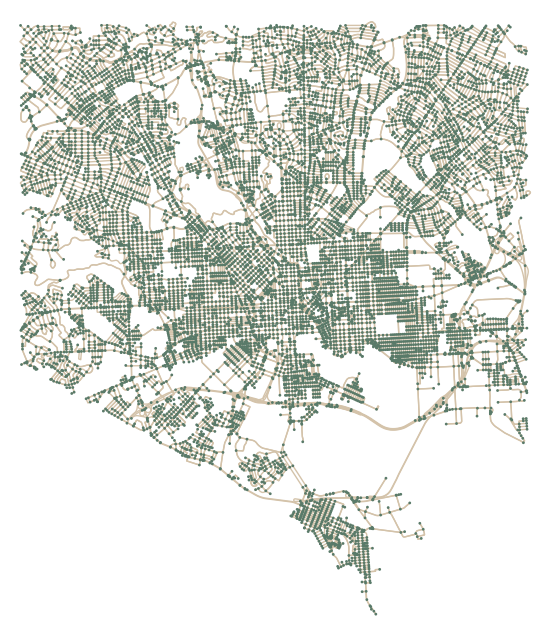

In [68]:
fig, ax = ox.plot.plot_graph(G, node_size=4, node_color='#597A69', node_zorder=2,bgcolor='w', edge_color='#D4C3AA')

In [69]:
# # 遍历所有边及其属性
# cnt = 0
# for u, v, key, data in G.edges(keys=True, data=True):
#     print(f"Edge ({u}, {v}, {key}): {data}")
#     cnt += 1
#     if cnt > 10:
#         break

In [70]:
# # 获取某个地点的街道网络及其面积（平方米）
# place = "Baltimore, Maryland, USA"
# gdf = ox.geocoder.geocode_to_gdf(place)
# area = ox.projection.project_gdf(gdf).union_all().area
# #G = ox.graph.graph_from_place(place, network_type="drive")

In [71]:
# 计算基本和扩展的网络统计数据，合并它们并显示
stats = ox.stats.basic_stats(G, area=area)
pd.Series(stats)

n                                                                           12602
m                                                                           32177
k_avg                                                                     5.10665
edge_length_total                                                  3820473.094512
edge_length_avg                                                        118.733042
streets_per_node_avg                                                      3.21449
streets_per_node_counts         {0: 0, 1: 1023, 2: 111, 3: 6754, 4: 4576, 5: 1...
streets_per_node_proportions    {0: 0.0, 1: 0.08117759085859387, 2: 0.00880812...
intersection_count                                                          11579
street_length_total                                                2445277.846781
street_segment_count                                                        20142
street_length_avg                                                      121.401939
circuity_avg    

In [72]:
# # 将字典解包为单独的键值对
# stats = ox.stats.basic_stats(G, area=area)
# for k, count in stats["streets_per_node_counts"].items():
#     stats[f"{k}way_int_count"] = count
# for k, proportion in stats["streets_per_node_proportions"].items():
#     stats[f"{k}way_int_prop"] = proportion

# # 删除不再需要的字典元素
# del stats["streets_per_node_counts"]
# del stats["streets_per_node_proportions"]

# # 加载为pandas数据框
# pd.DataFrame(pd.Series(stats, name="value")).round(3)

In [74]:
# 使用G的无向图 计算介数中心性
bc = nx.betweenness_centrality(ox.convert.to_undirected(G), weight="travel_time", normalized=False, k = 1000)
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(49400323, 13055699.858773323)

In [102]:
# 按中心性值降序排序，生成(节点ID, 中心性值)的列表
sorted_bc = sorted(bc.items(), key=lambda item: item[1], reverse=True)

# 提取前10个节点及其中心性值
n = 10
top_10_nodes = sorted_bc[:n]
top_100_nodes = sorted_bc[:100]
top_10_ids = [node for node, _ in top_10_nodes]  # <--- 添加这行关键定义
top_100_ids = [node for node, _ in top_100_nodes]
# 打印结果
# for node, centrality in top_10_nodes:
#     print(f"节点 {node}: 中介中心性 = {centrality}")

In [ ]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

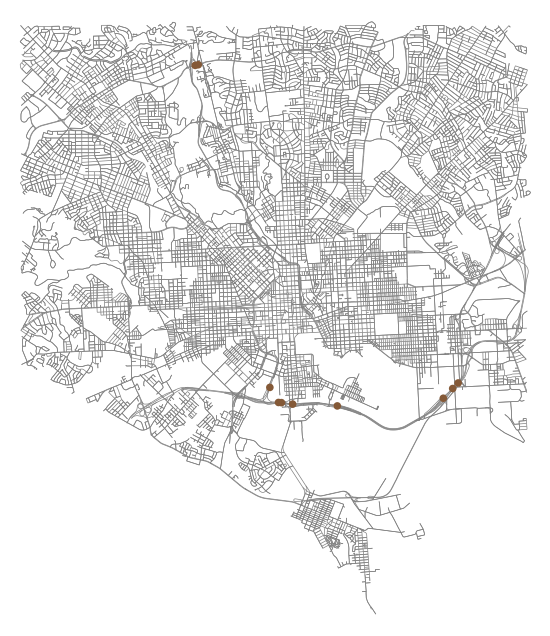

In [100]:
import osmnx as ox
import matplotlib.pyplot as plt

# 生成节点颜色和大小列表
node_colors = []
node_sizes = []
for node in G.nodes():
    if node in top_10_ids:
        node_colors.append("#845937")  # 高中心性节点设为红色
        node_sizes.append(30)      # 节点大小放大
    else:
        node_colors.append("lightgray")  # 普通节点设为浅灰
        node_sizes.append(0)            # 默认大小

# 绘制完整路网图并高亮关键节点
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,   # 应用自定义颜色列表
    node_size=node_sizes,     # 应用自定义大小
    edge_color="gray",        # 边颜色设为灰色
    edge_linewidth=0.5,       # 边线宽
    show=False,               # 不自动显示（用于后续叠加操作）
    close=False,              # 不关闭绘图对象
    bgcolor="white"           # 背景设为白色
)

In [107]:
import osmnx as ox
import pandas as pd

# 提取节点地理信息（兼容新版OSMnx）
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 筛选前10节点并保存
top_nodes = nodes_gdf.loc[top_10_ids]
result_df = pd.DataFrame({
    "osmid": top_nodes.index,
    "longitude": top_nodes.geometry.x,
    "latitude": top_nodes.geometry.y
})
result_df.to_csv("top_10_nodes.csv", index=False)

# 验证输出
print("已保存以下坐标到文件：")
print(result_df)

已保存以下坐标到文件：
                 osmid  longitude   latitude
osmid                                       
49400323      49400323 -76.617844  39.267360
49473119      49473119 -76.613826  39.266941
49436654      49436654 -76.618904  39.267407
365473916    365473916 -76.556514  39.271273
49473262      49473262 -76.559872  39.268579
49473153      49473153 -76.597842  39.266452
49473282      49473282 -76.554551  39.272814
49398589      49398589 -76.648749  39.360850
4890621392  4890621392 -76.647629  39.361030
49436683      49436683 -76.622000  39.271580


In [ ]:
# 将介数中心性值添加为新的节点属性，然后绘图
nx.set_node_attributes(G, bc, "bc")
# 生成节点颜色和大小列表
node_colors = []
node_sizes = []
for node in G.nodes():
    if node in top_10_ids:
        node_colors.append("#845937")  # 高中心性节点设为红色
        node_sizes.append(30)      # 节点大小放大
    elif node in top_100_ids:
        node_colors.append("#B89886")  # 普通节点设为浅灰
        node_sizes.append(20)            # 默认大小
fig, ax = ox.plot.plot_graph(
    G,
    node_color=node_colors,
    node_size=node_sizes,
    node_zorder=2,
    edge_linewidth=1,
    edge_color="#B2B2A8",
    bgcolor= 'white'
)

In [32]:
def add_traffic_flow_attribute(G):
    """
    为图的每条边添加车流量属性，计算方式为两端节点的中介中心性均值
    参数：
    G -- NetworkX图对象（支持Graph/DiGraph/MultiGraph/MultiDiGraph）
    """
    # 遍历所有边（包含MultiGraph的key）
    for u, v, key in G.edges(keys=True):
        try:
            # 获取两端节点的中介中心性
            bc_u = G.nodes[u]['bc']
            bc_v = G.nodes[v]['bc']
            
            # 计算车流量（保留4位小数）
            traffic_flow = round((bc_u + bc_v) / 2, 4)
            
            # 添加边属性（兼容不同图类型）
            if G.is_multigraph():
                G[u][v][key]['traffic_flow'] = traffic_flow
            else:
                G[u][v]['traffic_flow'] = traffic_flow
                
        except KeyError as e:
            print(f"警告：节点 {e} 缺少'bc'属性，跳过边 ({u}, {v}, {key})")
            
    return G


G = add_traffic_flow_attribute(G)



In [58]:
import pandas as pd

def parse_speed_value(speed_str):
    """从字符串中提取数值（兼容多单位和格式）"""
    try:
        # 移除括号和多余描述（如 "[15 mph, 25 mph]" -> "15 mph, 25 mph"）
        clean_str = str(speed_str).strip("[]")
        # 分割多个速度值
        speed_values = [s.strip() for s in clean_str.split(",")]
        
        total = 0.0
        valid_count = 0
        
        for s in speed_values:
            # 提取数字部分（兼容 "15 mph" 或 "25" 格式）
            num_str = ''.join(filter(lambda x: x.isdigit() or x == '.', s.split()[0]))
            if num_str:
                total += float(num_str)
                valid_count += 1
                
        return total / valid_count if valid_count > 0 else None
    except:
        return None

def calculate_te0(data):
    """增强版 te0 计算（支持多值 maxspeed）"""
    # 处理 maxspeed 字段
    speed_input = data.get("maxspeed", "30 mph")
    
    # 解析速度值（自动处理列表或字符串）
    avg_mph = parse_speed_value(speed_input)
    
    # 设置默认值
    if avg_mph is None or pd.isna(avg_mph):
        avg_mph = 30.0  # 默认30 mph
        print(f"使用默认速度 30 mph (原始数据: {speed_input})")

    # 单位转换：mph → m/s
    maxspeed_mps = avg_mph * 1609.344 / 3600
    
    # 处理 length 字段（单位：米）
    try:
        length = float(data["length"])
    except KeyError:
        raise ValueError("缺少必需的 length 字段")
    
    return length / maxspeed_mps

# 使用示例
test_cases = [
    {"maxspeed": ["15 mph", "25 mph"], "length": 1609.344},  # 平均20 mph → te0=120.7秒
    {"maxspeed": "30 mph", "length": 1000},                 # 直接解析 → te0=74.56秒
    {"maxspeed": ['45, 35 mph'], "length": 2000},           # 平均40 mph → te0=111.76秒
    {"maxspeed": "invalid", "length": 500},                 # 使用默认值30 mph → te0=37.28秒
]

for case in test_cases:
    try:
        te0 = calculate_te0(case)
        print(f"长度: {case['length']}m | 解析速度: {case['maxspeed']} | te0 = {te0:.2f}秒")
    except Exception as e:
        print(f"错误: {str(e)}")

长度: 1609.344m | 解析速度: ['15 mph', '25 mph'] | te0 = 180.00秒
长度: 1000m | 解析速度: 30 mph | te0 = 74.56秒
长度: 2000m | 解析速度: ['45, 35 mph'] | te0 = 111.85秒
使用默认速度 30 mph (原始数据: invalid)
长度: 500m | 解析速度: invalid | te0 = 37.28秒


In [33]:
cntt = 0
# 验证结果
for u, v, key in G.edges(keys=True):
    print(f"边 ({u}->{v}, key={key}) 车流量: {G[u][v][key]['traffic_flow']}")
    cntt+=1
    if cntt>10: break
    

边 (27033798->2703504304, key=0) 车流量: 9653227.4125
边 (27033900->49432572, key=0) 车流量: 7645664.7763
边 (27033900->27033915, key=0) 车流量: 10125843.6152
边 (27033915->832197543, key=0) 车流量: 8927682.9599
边 (33131447->7580785278, key=0) 车流量: 8868543.246
边 (33131447->49408167, key=0) 车流量: 16475440.2588
边 (33131448->33131447, key=0) 车流量: 16882682.1495
边 (33131472->832289021, key=0) 车流量: 15426282.202
边 (37431592->49560475, key=0) 车流量: 12554.0
边 (37564728->49486415, key=0) 车流量: 12554.0
边 (37585185->1948396902, key=0) 车流量: 12554.0


## 计算real_time

In [59]:
import pandas as pd
from ast import literal_eval

def parse_list_value(raw_value, mode='mean', default=2.0):
    """
    通用多值解析函数（支持列表/字符串/数值）
    
    参数：
    raw_value -- 原始输入值（可能是列表、字符串或数值）
    mode -- 处理模式：mean(平均)/max(最大)/min(最小)，默认mean
    default -- 解析失败时返回的默认值
    
    返回：
    解析后的数值（浮点型）
    """
    try:
        # 统一转换为列表格式
        if isinstance(raw_value, str):
            # 尝试解析字符串形式的列表（如 "['3','4']" → ['3','4']）
            if raw_value.startswith(('[')) and raw_value.endswith(']'):
                parsed_list = literal_eval(raw_value)
            else:
                # 处理用分隔符分割的值（如 "3-4" → ['3','4']）
                parsed_list = raw_value.replace(',', ' ').split()
        elif isinstance(raw_value, (int, float)):
            return float(raw_value)  # 直接返回数值
        else:
            parsed_list = list(raw_value)
        
        # 提取有效数值
        numbers = []
        for item in parsed_list:
            try:
                num = float(''.join(filter(lambda x: x.isdigit() or x == '.', str(item))))
                numbers.append(num)
            except:
                continue
        
        if not numbers:
            return default
        
        # 根据模式计算结果
        if mode == 'mean':
            return sum(numbers) / len(numbers)
        elif mode == 'max':
            return max(numbers)
        elif mode == 'min':
            return min(numbers)
        else:
            raise ValueError(f"未知模式: {mode}")
    
    except:
        return default

In [60]:
import pandas as pd

def safe_float_convert(value, default=2.0):
    """
    安全地将输入值转换为浮点数
    """
    try:
        return float(''.join(filter(lambda x: x.isdigit() or x == '.', str(value))))
    except:
        return default

# 遍历所有边
for u, v, key, data in G.edges(keys=True, data=True):
    a = 0.15
    b = 4
    
    te0 = calculate_te0(data)
    
    raw_lanes = data.get("lanes", "2")
    data["lanes"] = parse_list_value(raw_lanes, mode='mean')  # 使用平均值策略
    
    # 计算实时时间
    data["real_time"] = te0 * (1 + a * (data["traffic_flow"] / data["lanes"])**b)

In [61]:
bc_real = nx.betweenness_centrality(ox.convert.to_digraph(G), weight="real_time", normalized=False)
nx.set_node_attributes(G, bc_real, "bc_real")

In [ ]:
nc = ox.plot.get_edge_colors_by_attr(G, "bc_real", cmap="plasma")  #node colour
fig, ax = ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=20,
    node_zorder=2,
    edge_linewidth=0.5,
    edge_color="black",
    bgcolor= 'white'
)

### closeness

In [87]:
# # 将图转换为线图，使边变为节点，反之亦然(并没有这样做)
# edge_centrality = nx.closeness_centrality(nx.line_graph(G))
# nx.set_edge_attributes(G, edge_centrality, "edge_centrality")
node_centrality = nx.closeness_centrality((G))


In [111]:
#nx.set_node_attributes(G, node_centrality, "node_centrality")
# 按中心性值降序排序，生成(节点ID, 中心性值)的列表
sorted_nc = sorted(node_centrality.items(), key=lambda item: item[1], reverse=True)

# 提取前10个节点及其中心性值
n = 10
top_10_nodes2 = sorted_nc[:n]
#top_100_nodes = sorted_nc[:100]
top_10_ids2 = [node for node, _ in top_10_nodes2]  # <--- 添加这行关键定义
#top_100_ids = [node for node, _ in top_100_nodes]
# 打印结果
# for node, ncentrality in top_10_nodes2:
#      print(f"节点 {node}: 接近中心性 = {node_centrality}")

In [112]:
import osmnx as ox
import pandas as pd

# 提取节点地理信息（兼容新版OSMnx）
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 筛选前10节点并保存
top_nodes = nodes_gdf.loc[top_10_ids2]
result_df = pd.DataFrame({
    "osmid": top_nodes.index,
    "longitude": top_nodes.geometry.x,
    "latitude": top_nodes.geometry.y
})
result_df.to_csv("top_10_nodes2.csv", index=False)

# 验证输出
print("已保存以下坐标到文件：")
print(result_df)

已保存以下坐标到文件：
               osmid  longitude   latitude
osmid                                     
49519959    49519959 -76.618658  39.304414
610457975  610457975 -76.617435  39.303402
49444756    49444756 -76.618399  39.303351
49380500    49380500 -76.607501  39.290638
49457522    49457522 -76.611255  39.293681
49434647    49434647 -76.617635  39.306579
610457875  610457875 -76.619483  39.306478
49486730    49486730 -76.611177  39.292452
49567904    49567904 -76.620275  39.301718
49469485    49469485 -76.611667  39.299814


### detour ratio 绕路

In [ ]:
# 这两个节点之间的直线距离是多少？
# 使用 OSMnx 的矢量化大圆距离（haversine）函数
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
d = round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

In [ ]:
# 使用距离模块获取两个经纬度点的最近网络节点
orig = ox.distance.nearest_nodes(G, X=-76.629244, Y=39.317355)
# dest = ox.distance.nearest_nodes(G, X=-76.601399, Y=39.288630)
dest = ox.distance.nearest_nodes(G, X=-76.579977, Y=39.262618)

In [ ]:
# 找到节点之间的最短路径，最小化旅行时间，然后绘制它
route = ox.routing.shortest_path(G, orig, dest, weight="travel_time")
#fig, ax = ox.plot.plot_graph_route(G, route, node_size=0)

# 我们的路线长度是多少米？
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
dd = round(sum(edge_lengths))

In [ ]:
detour_ratio = d / dd